# Shallow Water Examples - Neural Operator Pytorch

### Imports and global settings

In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load data

In [2]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


### SFNO Model

In [3]:
model = SFNO(n_modes=(32, 32),
             in_channels=3,
             out_channels=3,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 275555 parameters.


### Hyperparameters, scheduler, optimizer

In [4]:
optimizer = AdamW(model.parameters(),
                                lr=8e-4,
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projectio

### SFNO training

In [5]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 200 samples
Testing on [50, 50] samples         on resolutions [(32, 64), (64, 128)].
Raw outputs of shape torch.Size([4, 3, 32, 64])
[0] time=2.13, avg_loss=2.6087, train_err=10.4347
Eval: (32, 64)_l2=1.8656, (64, 128)_l2=2.4123
[3] time=1.79, avg_loss=0.4075, train_err=1.6302
Eval: (32, 64)_l2=0.5359, (64, 128)_l2=2.6461
[6] time=1.75, avg_loss=0.2704, train_err=1.0818
Eval: (32, 64)_l2=0.5076, (64, 128)_l2=2.5539
[9] time=1.80, avg_loss=0.2249, train_err=0.8996
Eval: (32, 64)_l2=0.4164, (64, 128)_l2=2.5011
[12] time=1.75, avg_loss=0.2011, train_err=0.8044
Eval: (32, 64)_l2=0.3867, (64, 128)_l2=2.4811
[15] time=1.76, avg_loss=0.1675, train_err=0.6699
Eval: (32, 64)_l2=0.3930, (64, 128)_l2=2.4838
[18] time=1.80, avg_loss=0.1539, train_err=0.6156
Eval: (32, 64)_l2=0.3705, (64, 128)_l2=2.4502


{'train_err': 0.582300386428833,
 'avg_loss': 0.14557509660720824,
 'avg_lasso_loss': None,
 'epoch_train_time': 1.81527844499999}

### Visualization of the results

/tmp/ipykernel_3801/2782922215.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


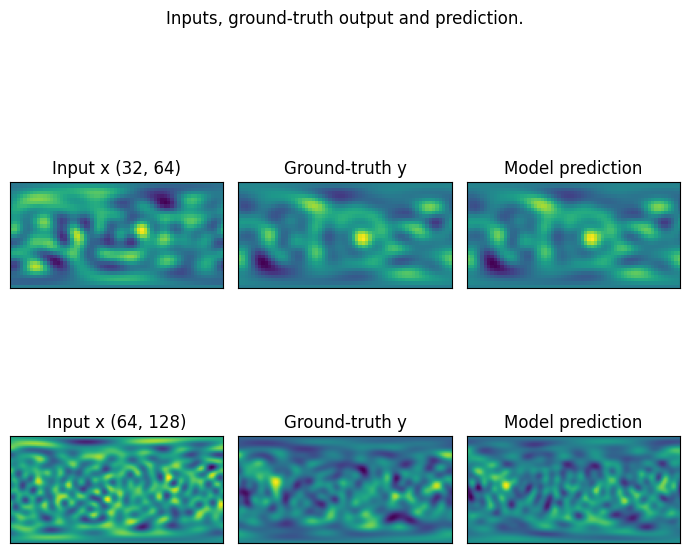

In [ ]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    x = data['x']
    y = data['y'][0, ...].numpy()
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()